# Finite-Time Lyapunov Exponent (FTLE)
In this example, we will compute the finite-time Laypunov exponent (FTLE) field for a co-rotating vortex pair.

In [1]:
using ILMPostProcessing
using ViscousFlow
using Plots

## Setup the Co-rotating Vortices Problem
The grid Re number is chosen at 10.0 to speed up computations.

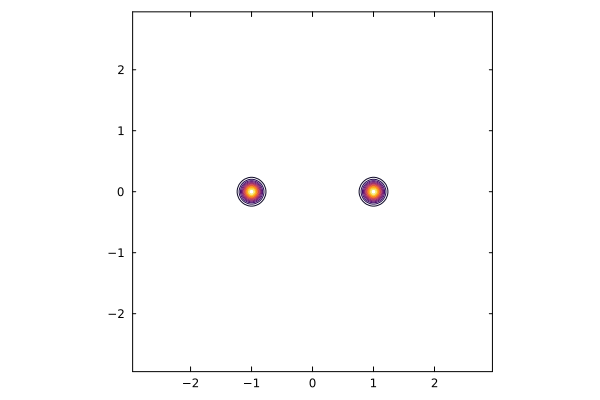

In [2]:
my_params = Dict()
my_params["Re"] = 300
xlim = (-3.0,3.0)
ylim = (-3.0,3.0)
my_params["grid Re"] = 10.0

g = setup_grid(xlim,ylim,my_params)

sys = viscousflow_system(g,phys_params=my_params)

σ = 0.1
x01, y01 = 1.0, 0.0
x02, y02 = -1.0, 0.0
A = 3
twogauss = SpatialGaussian(σ,σ,x01,y01,A) + SpatialGaussian(σ,σ,x02,y02,A)

u0 = init_sol(twogauss,sys)

plot(vorticity(u0,sys,0.0),sys)

## Solve the Problem
Step the integrator repeatedly until the solution is generated for t = (0.0, 18.0).

 18.544020 seconds (4.87 M allocations: 8.858 GiB, 2.10% gc time, 9.01% compilation time)


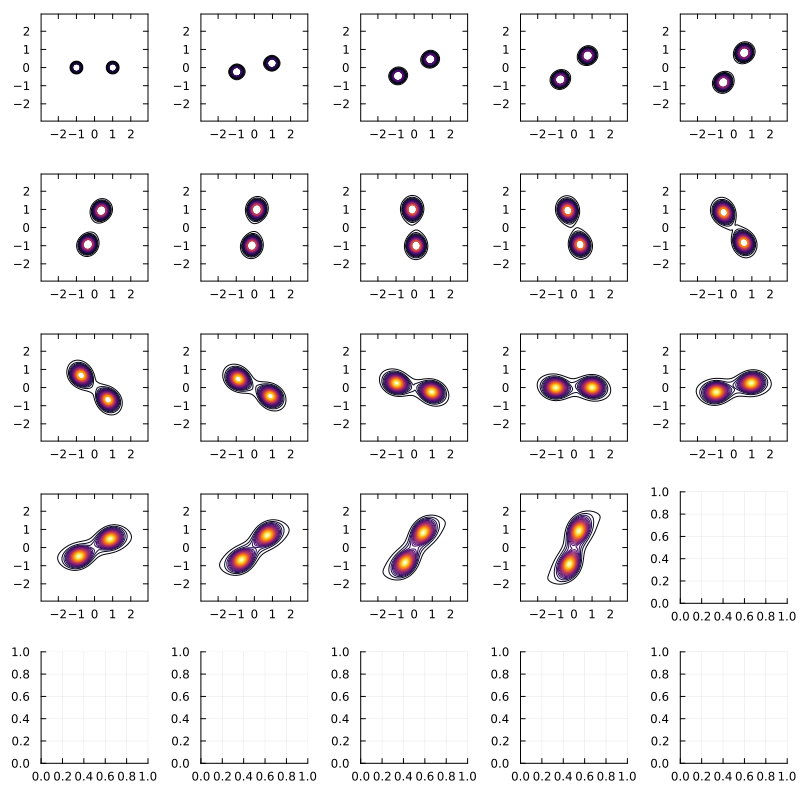

In [3]:
T = 18.0
tspan = (0.0,T)
integrator = init(u0,tspan,sys)

@time begin
    step!(integrator,T)
end

sol = integrator.sol

plt = plot(layout = (5,5), size = (800, 800), legend=:false)
tsnap = 0.0:1.0:T
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,levels=range(0.1,5,length=31))
end
savefig(plt,"CoRotating.pdf")
plt

## Discretize the Solution in Time
This step stores the velocity fields as interpolatable fields at chosen time steps so that the velocity fields don't need to be computed every iteration the IVP is solved.

In [4]:
u = []
v = []
t_start = 0.0
t_end = 18.0
dt = 0.01

ILMPostProcessing.make_interp_fields!(u, v, t_start, t_end, dt, ViscousFlow.velocity, sol, sys, g)

## Generate Initial Conditions

In [5]:
X_MIN = -2.0
X_MAX = 2.0
Y_MIN = -2.0
Y_MAX = 2.0
nx, ny = 400, 400

initial_conditions, dx, dy = ILMPostProcessing.gen_init_conds(X_MIN, X_MAX, Y_MIN, Y_MAX, nx, ny)

([-2.0 -2.0; -2.0 -1.9899749373433584; … ; 2.0 1.9899749373433584; 2.0 2.0], 0.010025062656641603, 0.010025062656641603)

## Solve the IVP and Generate FTLE Fields
### Computing the FTLE Field at One Time Snapshot
Forward Euler's method is used here, but can also use ILMPostProcessing.adams_bashforth_2_forward.

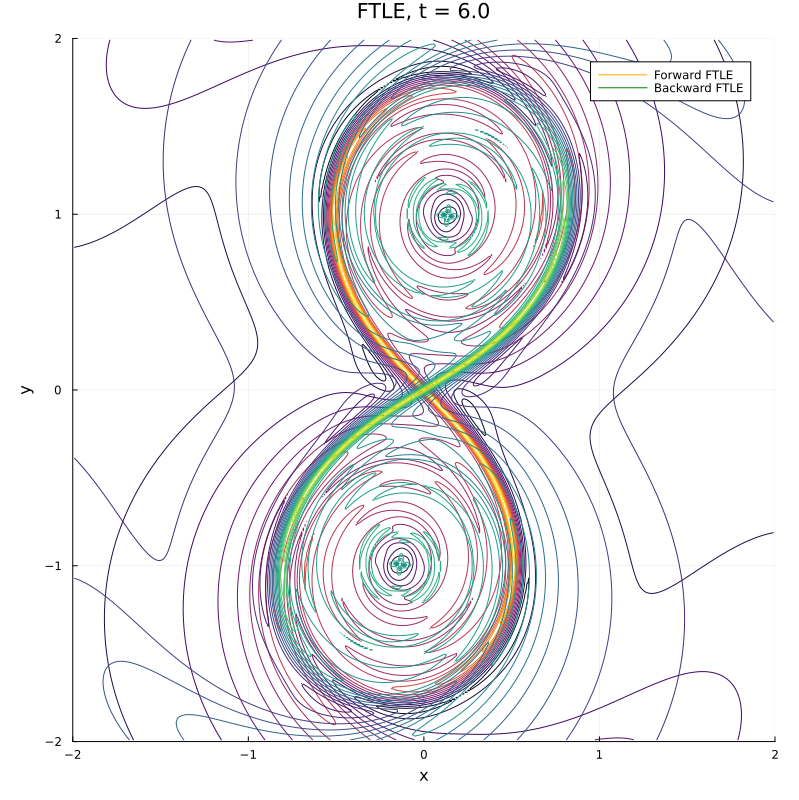

In [6]:
FTLE = zeros(Float64, ny - 2, nx - 2)
T = 6.0
t0 = 6.0

w = ILMPostProcessing.euler_forward(initial_conditions, u, v, t0, t_start, dt, T); # final trajectories from forward integration
z = ILMPostProcessing.euler_backward(initial_conditions, u, v, t0, t_start, dt, T); # final trajectories from backward integration

FTLE_forward = zeros(Float64, ny - 2, nx - 2)
ILMPostProcessing.compute_FTLE!(FTLE_forward, nx, ny, T, w, dx, dy);

FTLE_backward = zeros(Float64, ny - 2, nx - 2)
ILMPostProcessing.compute_FTLE!(FTLE_backward, nx, ny, T, z, dx, dy);

x = range(X_MIN + dx, stop = X_MAX - dx, length=nx - 2)
y = range(Y_MIN + dy, stop = Y_MAX - dy, length=ny - 2)

contour(x, y, FTLE_forward, fill=false, title="FTLE, t = $t0", xlabel="x", ylabel="y", colorbar=false, c=:inferno, ratio = 1, xlim = (-2, 2), ylim = (-2, 2), size = (800, 800), label = "Forward FTLE", legend=:topright)
contour!(x, y, FTLE_backward, fill=false, colorbar=false, c=:viridis)

plot!([], [], label="Forward FTLE", linecolor=:orange)
plot!([], [], label="Backward FTLE", linecolor=:green)

### Computing the FTLE Fields at a Range of Times and Generate GIF
Also advances the trajectories of a group of points. The first example places initial points near the unstable manifold (orange).

In [7]:
x_min = -1.0
x_max = 0.0
y_min = 0.5
y_max = 1.5
nx_p, ny_p = 10, 10

initial_points, dx_p, dy_p = ILMPostProcessing.gen_init_conds(x_min, x_max, y_min, y_max, nx_p, ny_p)

FTLE = zeros(Float64, ny - 2, nx - 2)
T = 6.0

6.0

The code here creates a gif

    @gif for t0 in 6.0:0.5:12.0
        print(t0)

        points = ILMPostProcessing.euler_forward(initial_points, u, v, 6.0, t_start, dt, t0 - 6.0)

        w = ILMPostProcessing.euler_forward(initial_conditions, u, v, t0, t_start, dt, T); # final trajectories from forward integration
        z = ILMPostProcessing.euler_backward(initial_conditions, u, v, t0, t_start, dt, T); # final trajectories from backward integration

        FTLE_forward = zeros(Float64, ny - 2, nx - 2)
        ILMPostProcessing.compute_FTLE!(FTLE_forward, nx, ny, T, w, dx, dy);

        FTLE_backward = zeros(Float64, ny - 2, nx - 2)
        ILMPostProcessing.compute_FTLE!(FTLE_backward, nx, ny, T, z, dx, dy);

        x = range(X_MIN + dx, stop = X_MAX - dx, length=nx - 2)
        y = range(Y_MIN + dy, stop = Y_MAX - dy, length=ny - 2)

        contour(x, y, FTLE_forward, fill=false, title="FTLE, t = $t0", xlabel="x", ylabel="y", colorbar=false, c=:inferno, xlim = (-2, 2), ylim = (-2, 2), ratio = 1, size = (800, 800))
        contour!(x, y, FTLE_backward, fill=false, colorbar=false, c=:viridis)

        plot!([], [], label="Forward FTLE", linecolor=:orange)
        plot!([], [], label="Backward FTLE", linecolor=:green)
        scatter!(points[:,1], points[:,2], label = "Points", markercolor=:black, legend=:topright)
    end every 1 fps = 2

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*